In [51]:
import datetime
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
import xgboost as xgb
import shap
%matplotlib inline
sns.set(color_codes=True)

# Loading data

In [52]:
PICKLE_TRAIN_DIR=os.path.join("..", 'processed_data', 'train_data.pkl')
PICKLE_PRICING_DIR=os.path.join("..", 'processed_data', 'pricing_data.pkl')

In [53]:
train_data=pd.read_pickle(PICKLE_TRAIN_DIR)
pricing_data=pd.read_pickle(PICKLE_PRICING_DIR)

In [54]:
#merge two dataframes
train=pd.merge(train_data, pricing_data, on='id')

In [55]:
train.dtypes

id                           object
cons_12m                    float64
cons_gas_12m                float64
cons_last_month             float64
forecast_cons_12m           float64
forecast_discount_energy    float64
forecast_meter_rent_12m     float64
forecast_price_energy_p1    float64
forecast_price_energy_p2    float64
forecast_price_pow_p1       float64
has_gas                       int64
imp_cons                    float64
margin_gross_pow_ele        float64
margin_net_pow_ele          float64
nb_prod_act                   int64
net_margin                  float64
pow_max                     float64
churn                         int64
tenure_year                   int32
months_activ                float64
months_to_end               float64
months_modif_prod           float64
months_renewal              float64
channel_epu                   uint8
channel_ewp                   uint8
channel_fix                   uint8
channel_foo                   uint8
channel_lmk                 

# Splitting data

In [56]:
X=train.drop(columns=['id','churn'],axis=1)
y=train['churn']

In [57]:
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=18)

# Modeling (XGBoost)

In [58]:
model=xgb.XGBClassifier(learning_rate=0.1, max_depth=6, n_estimators=500, random_state=18)
model.fit(X_train, y_train)
model.predict(X_test)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:52:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

# Model evaluation

## Accuracy, precision, recall

In [59]:
def evaluate(model_, X_test_, y_test_):
    prediction_test_=model_.predict(X_test_)
    
    results= pd.DataFrame({'Accuracy': [metrics.accuracy_score(y_test_, prediction_test_)],
                          'Precision': [metrics.precision_score(y_test_, prediction_test_)],
                          'Recall': [metrics.recall_score(y_test_, prediction_test_)]})
    return results

In [60]:
evaluate(model, X_test, y_test)

,Accuracy,Precision,Recall
0,0.906561,0.73494,0.146988


## ROC-AUC

In [61]:
def calcuate_plot_roc_auc(model_, X_test_, y_test_):
    
    # model preduction for the class 1(churn)
    prediction_test_=model_.predict_proba(X_test_)[:,1]
    # compute roc-auc
    fpr, tpr, thresholds= metrics.roc_curve(y_test_, prediction_test_)
    auc_score=metrics.auc(fpr, tpr)
    
    # plot roc curve 
    f,ax=plt.subplots()
    ax.plot(fpr,tpr, label='AUC=%0.2f'%(auc_score))
    # plot the random line 
    plt.plot([0,1],[0,1],label='random')
    ax.set_xlabel('False positive rate (FPR)')
    ax.set_ylabel('True postive rate (TPR)')
    ax.set_title('ROC Curve')
    plt.legend()
    plt.show()
    return print('The AUC score is %f' % auc_score)

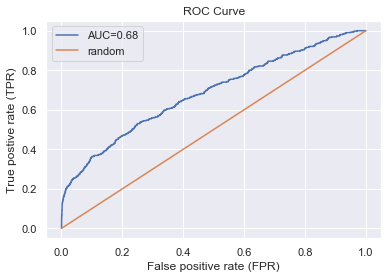

The AUC score is 0.684365


In [62]:
calcuate_plot_roc_auc(model, X_test, y_test)

## Stratified K-fold cross-validation

In [67]:
def plot_roc_curve(fprs, tprs):
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)
    f, ax= plt.subplots(figsize=(18,10))
    
    #plot roc for each k-fold 
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0]= 0.0
        roc_auc=metrics.auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, label="ROC fold %d (AUC= %0.2f)" %(i, roc_auc))
    
    #plot random line
    plt.plot([0,1], [0,1],label="Random")   
    
    #plot the mean roc
    mean_tpr=np.mean(tprs_interp, axis=0)
    mean_tpr[-1]=1.0
    mean_auc= metrics.auc(mean_fpr, mean_tpr)
    std_auc= np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, label="Mean ROC (AUC = %0.2f $\pm$ %0.2f)" %(mean_auc, std_auc))
    
    ax.set_xlabel('False positive rate (FPR)')
    ax.set_ylabel('True postive rate (TPR)')
    ax.set_title('ROC Curve')
    ax.legend()
    plt.show()
    return (f,ax)

def compute_roc_auc(model_, index):
    y_predict= model_.predict_proba(X.iloc[index])[:,-1]
    fpr, tpr, thresholds= metrics.roc_curve(y.iloc[index], y_predict)
    auc_score= metrics.auc(fpr,tpr)
    return fpr,tpr, auc_score

In [64]:
cv= StratifiedKFold(n_splits=5, random_state=13, shuffle=True)
fprs, tprs, scores= [], [], []

In [68]:
for (train, test), i in zip(cv.split(X,y),range(5)):
    model.fit(X.iloc[train],y.iloc[train])
    _, _, auc_score_train =compute_roc_auc(model, train)
    fpr, tpr, auc_score=compute_roc_auc(model, test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[16:04:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:04:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:04:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:04:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

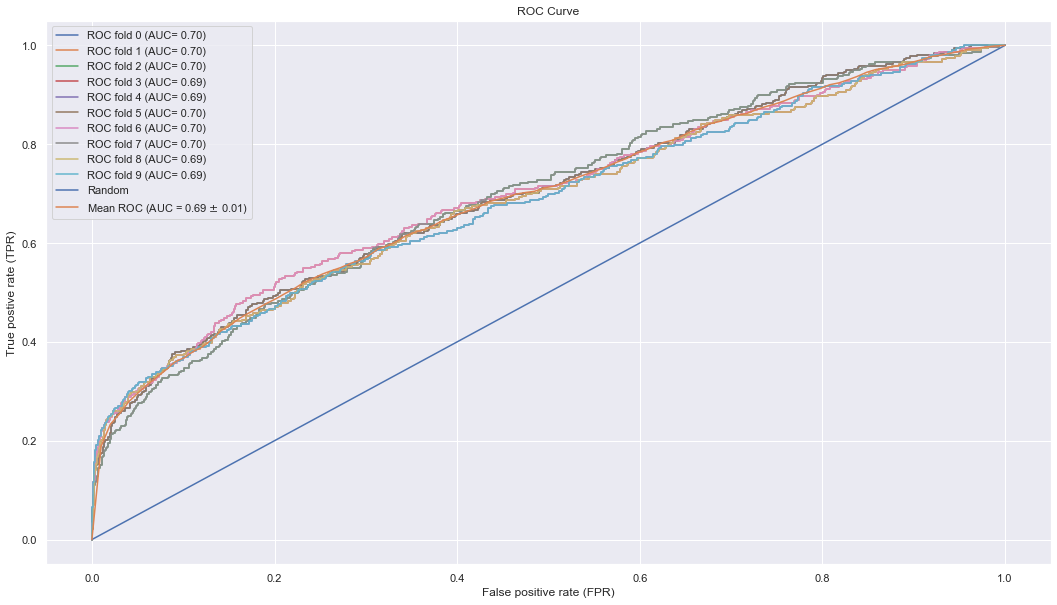

In [69]:
plot_roc_curve(fprs, tprs)
plt.show()

# Model finetuning

In [70]:
from sklearn.model_selection import RandomizedSearchCV

# create random grid
params={'n_estimators':[i for i in np.arange(0,2000,100)],
        'max_depth':[i for i in np.arange(1,15,1)],
        'learning_rate':[i for i in np.arange(0,0.15,0.01)] 
}

In [71]:
xg=xgb.XGBClassifier(objective='binary:logistic', silent=True, nthred=1)
xg_random=RandomizedSearchCV(xg, param_distributions=params, n_iter=1, scoring='roc_auc', 
                             n_jobs=4, cv=5, verbose=3, random_state=1001)
xg_random.fit(X_train, y_train)
xg_random.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:   18.8s remaining:   28.2s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   26.4s finished
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[16:05:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { nthred, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:05:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'n_estimators': 1300, 'max_depth': 8, 'learning_rate': 0.1}

In [72]:
model_random=xgb.XGBClassifier(objective='binary:logistic', silent=True, nthread=1, **xg_random.best_params_)
model_random

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=8,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1300, n_jobs=None, nthread=1, num_parallel_tree=None,
              objective='binary:logistic', random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, silent=True,
              subsample=None, tree_method=None, use_label_encoder=True,
              validate_parameters=None, verbosity=None)

In [73]:
fprs, tprs, scores=[], [], []

for (train, test), i in zip(cv.split(X,y),range(5)):
    model_random.fit(X.iloc[train],y.iloc[train])
    _, _, auc_score_train =compute_roc_auc(model_random, train)
    fpr, tpr, auc_score=compute_roc_auc(model_random, test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[16:05:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:05:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:06:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip

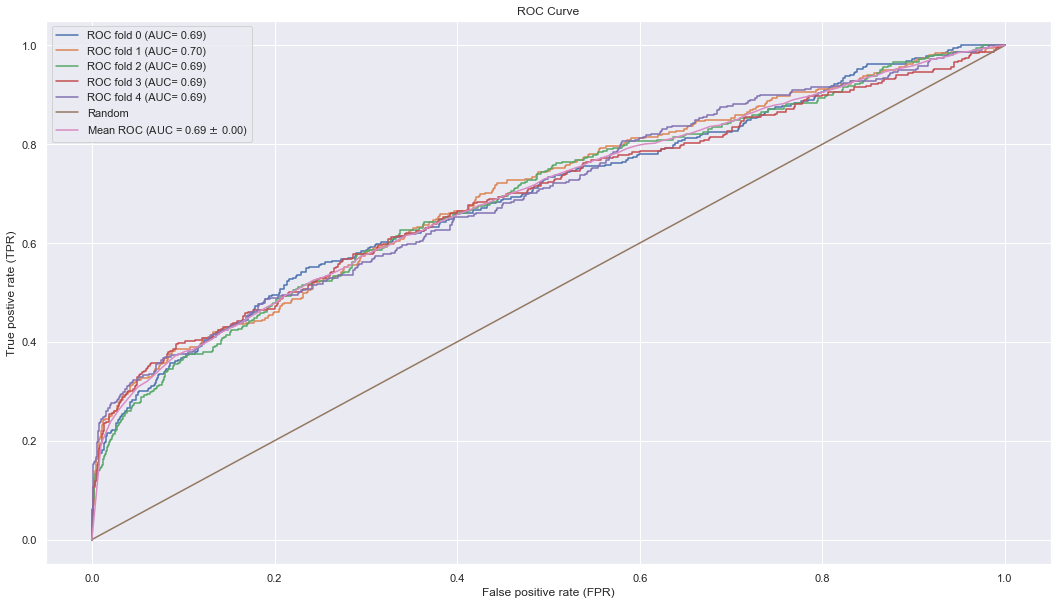

In [75]:
plot_roc_curve(fprs,tprs)
plt.show()

# Understanding the model

## Plot features ordered by their importance

In [ ]:
fig,ax= plt.subplots(figsize=(15,20))
xgb.plot_importance(model, ax=ax)

In [ ]:
plt.figure(figsize=(100,80)) 
xgb.plot_tree(model, ax=plt.gca())

**In the feature inportance graph above we can see that cons_12m and net_margin are the features that apppear the most in our model and we could intere that these two features have a siginigivant importance in our model.**

In [ ]:
explainer=shap.TreeExplainer(model)
shap_values=explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')